# Check lib versions

In [41]:
%%bash
# Check nvcc version
nvcc -V
echo
# Check GCC version
gcc --version
echo
# Check the version of torch and cuda packages
pip list | grep "torch\|cuda"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0

gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.


cuda-python                   11.6.1
cupy-cuda115                  9.6.0
dask-cuda                     22.4.0
nvidia-dali-cuda110           1.13.0
pytorch-quantization          2.1.2
torch                         1.12.0a0+8a1a93a
torch-tensorrt                1.1.0a0
torchtext                     0.13.0a0
torchvision                   0.13.0a0


# Setup Weights & Biases

In [42]:
# !pip install -q --upgrade wandb


# import os
# os.environ["WANDB_NOTEBOOK_NAME"] = "pigtracking_prediction.ipynb"
# import wandb
# wandb.login()

# wandb.__version__

In [43]:
# import wandb
# import os

# os.environ["WANDB_NOTEBOOK_NAME"] = "mmdetecttion_custom_dataset"

# wandb.init(project="animaltracking", entity="mjirik")

In [80]:
# Some basic setup


import sys
from pathlib import Path

sys.path.insert(0, str(Path(".").absolute().parent.absolute()))

# import some common libraries
import logging
import mmcv.utils

logger = mmcv.utils.get_logger(name="general_logger", log_level=logging.DEBUG)

import matplotlib.pyplot as plt
import numpy as np

# Check Pytorch installation
import torch, torchvision

print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet

logger.debug(f"mmdet.version={mmdet.__version__}")

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

logger.debug(get_compiling_cuda_version())
logger.debug(get_compiler_version())
from pprint import pprint, pformat
from mmdet.datasets import build_dataset
from mmdet.apis import train_detector
from mmcv import Config
from mmdet.apis import set_random_seed
from pathlib import Path
import os.path as osp
import os
import mmcv
from mmcv.runner import load_checkpoint
from typing import Optional

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

import skimage
import random
from pathlib import Path
import cv2
import json

%load_ext autoreload
%autoreload 2
import visualization


2022-11-11 15:20:24,990 - general_logger - DEBUG - mmdet.version=2.25.0
2022-11-11 15:20:24,991 - general_logger - DEBUG - 11.7
2022-11-11 15:20:24,992 - general_logger - DEBUG - GCC 9.4


1.12.0a0+8a1a93a True
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
mmdet.__version__

'2.25.0'

# Prepare data

Download and copy dataset to scratch dir.

In [82]:
scratchdir = Path(os.getenv("SCRATCHDIR", "."))
logname = Path(os.getenv("LOGNAME", "."))
# from loguru import logger

# input_dirs = list(Path(
#     "/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/"
# ).glob("20*"))



# local_input_data_dir = Path(scratchdir) / "data/orig/"
local_output_data_dir = Path(scratchdir) / "data/processed/"

# Set input path to videos

In [83]:
mask_pth = Path("/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/cam1_mask2.png")

# last generated
# input_dir = sorted(list(Path("/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/").glob("20*/*.mp4")))[-1].parent

# Sample
input_dir = Path("/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/zverinec-top-view")
input_dir

PosixPath('/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/zverinec-top-view')

In [84]:


# fn = np.random.choice(list(Path(
fns = np.random.choice(list(Path(
    input_dir
    # "/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/"
# ).glob("20*/*.mp4"))[0]
# ).glob("zverinec*/*.mp4")),size=2)
).glob("*.mp4")),size=2)
fn=fns[0]
fns


array([PosixPath('/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/zverinec-top-view/zverinec01-001.mp4'),
       PosixPath('/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/zverinec-top-view/zverinec01-001.mp4')],
      dtype=object)

In [85]:
# !mkdir -p ~/data/orig/cocos2d
# # !cd ~/data/orig/cocos2d
# !wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip -O data.zip
# !unzip -o data.zip -d "$SCRATCHDIR"/data/orig/cocos2d > /dev/null
# !pwd

In [86]:
# !ls ~/data/orig/cocos2d

In [87]:
!echo "$SCRATCHDIR"

/scratch/mjirik/job_13257868.meta-pbs.metacentrum.cz


In [88]:
# !mkdir -p "$SCRATCHDIR"/data/orig
# # !cp -r /storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/* "$SCRATCHDIR"/data/orig
# !cp -r /storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/pigtracking.zip "$SCRATCHDIR"/data/orig
# !unzip -o "$SCRATCHDIR"/data/orig/pigtracking.zip -d "$SCRATCHDIR"/data/orig > /dev/null
# !ls "$SCRATCHDIR"/data/orig

In [89]:

!ls "$SCRATCHDIR"/data/orig

ls: cannot access '/scratch/mjirik/job_13257868.meta-pbs.metacentrum.cz/data/orig': No such file or directory


In [90]:
# import animaltracking.coco_dataset
# fnin = local_input_data_dir / 'annotations/instances_default.json'
# fn1 = local_input_data_dir / 'annotations/train.json'
# fn2 = local_input_data_dir / 'annotations/test.json'
# fn3 = local_input_data_dir / 'annotations/val.json'
# fntmp = local_input_data_dir / 'annotations/tmp.json'
# ccd = animaltracking.coco_dataset.CocoDataset(fnin, local_input_data_dir / "images")
# ccd.train_test_split(fn1, fntmp)
# ccd = animaltracking.coco_dataset.CocoDataset(fntmp, local_input_data_dir / "images")
# ccd.train_test_split(fn2, fn3, 0.5)
# fn3.exists()

# Prepare checkpoint

In [91]:
import requests
import tqdm
from mmdet.apis import init_detector, inference_detector
import mmcv
from matplotlib import pyplot as plt



In [92]:


mmdetection_path = Path(mmdet.__file__).parent.parent


# logger.debug(f"outputdir={local_output_data_dir}")
# logger.debug(f"input_data_dir={local_input_data_dir}")
# logger.debug(f"input_data_dir exists={local_input_data_dir.exists()}")
# logger.debug(f'input_data_dir glob={str(list(local_input_data_dir.glob("**/*")))}')

# Choose to use a config and initialize the detector
config_file = Path(
    mmdetection_path
    / "configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py"
)
logger.debug(f"config.exists={config_file.exists()}")
# Setup a checkpoint file to load
checkpoint_file= Path(
    "/storage/plzen4-ntis/projects/korpusy_cv/biomedical/processed/pigtracking/tutorial_exps/latest.pth"
)
logger.debug(f"checkpoint_pth.exists={checkpoint_file.exists()}")

# Set the device to be used for evaluation
device = "cuda:0"

config = mmcv.Config.fromfile(config_file)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None
config.model.roi_head.bbox_head.num_classes=1

model = init_detector(config, str(checkpoint_file), device=device)

# or save the visualization results to image files
# model.show_result(img, result, out_file='result.jpg')






2022-11-11 15:20:30,059 - general_logger - DEBUG - config.exists=True
2022-11-11 15:20:30,061 - general_logger - DEBUG - checkpoint_pth.exists=True


load checkpoint from local path: /storage/plzen4-ntis/projects/korpusy_cv/biomedical/processed/pigtracking/tutorial_exps/latest.pth


## Test model on one image

In [93]:

# # test a single image and show the results
# img_pth = Path("/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/images/frame_036987.PNG")
# # img = 'test.jpg'  # or img = mmcv.imread(img), which will only load it once
# result = inference_detector(model, img_pth)
# # visualize the results in a new window
# plt.imshow(model.show_result(img_pth, result))

## Test mask algorithm

In [94]:

class Masker():
    def __init__(self, mask_pth:Path):

        mask = skimage.io.imread(mask_pth, as_gray=True)
        mask = (mask > (0.5 * np.max(mask))).astype(float)
        self.mask3 = np.repeat(mask[:,:,np.newaxis], repeats=3, axis=2)
        
    def do_mask(self, img):
        tp = img.dtype
        return (img * self.mask3).astype(tp)
# mask_pth = Path("/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/cam1_mask2.png")
# ms = Masker(mask_pth)
# # mask3.shape
# im_masked = ms.do_mask(skimage.io.imread(img_pth))
# plt.imshow(im_masked)

# Process video

### Test one frame mask and detection

/workspace/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


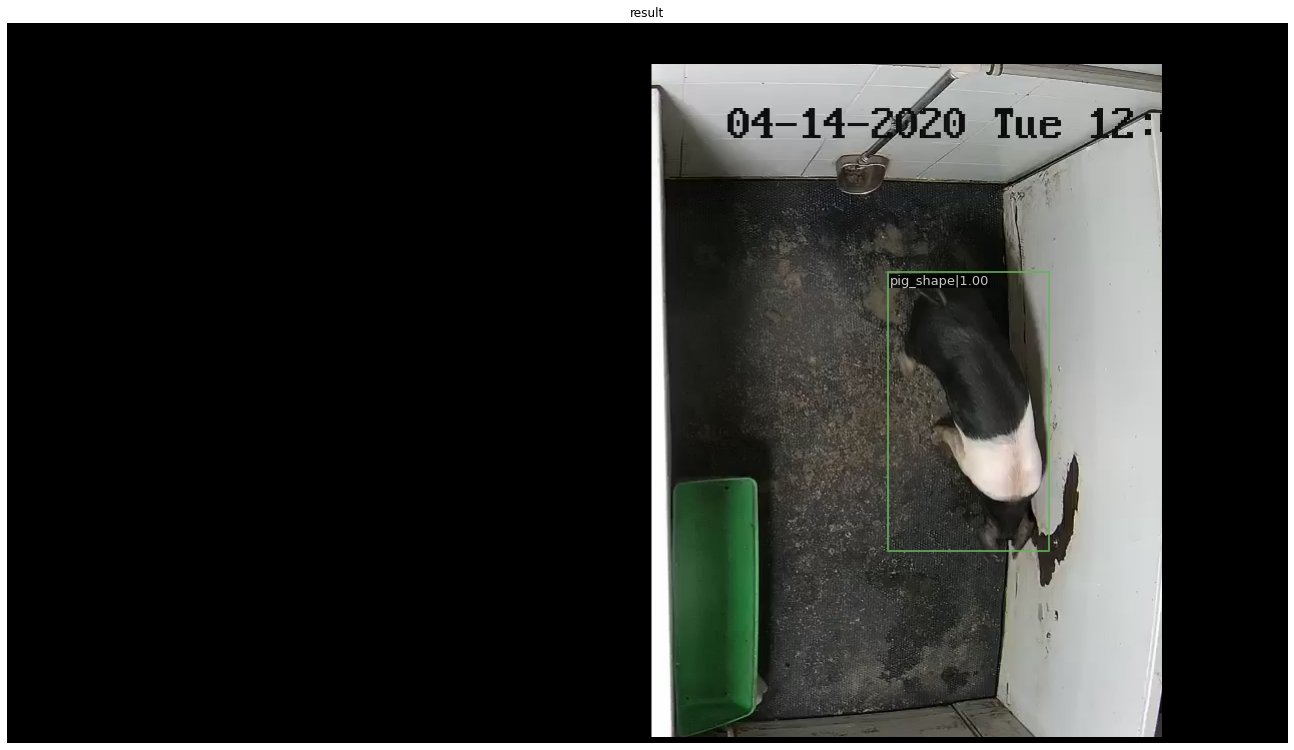

In [95]:
# do the checks
cap = cv2.VideoCapture(str(fn))
ms = Masker(mask_pth)
while cap.isOpened():
    # pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
    flag, frame = cap.read()
    if flag and frame is not None:
        result = inference_detector(model, ms.do_mask(frame)[...,::1])
        # imout = model.show_result(frame, result)
        show_result_pyplot(model, ms.do_mask(frame)[...,::1], result)
        break
        # video_writer.write(imout)
    
cap.release()

### Process whole video

In [96]:
import json
from json import JSONEncoder
import numpy

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [97]:
def get_video_writer(cap, filename):
      #output video
        filename = Path(filename)
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        size_input_video = [int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
                int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))]

        size_output_video = size_input_video.copy()
        # size_output_video[1] *= 2
        logger.debug(f"{size_input_video}, {size_output_video}")
        # fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        # video_name = '{}/pigleg_results.avi'.format(outputdir)
        videoWriter = cv2.VideoWriter(str(filename.with_suffix(".avi")), 
                                      fourcc, 
                                      fps, size_output_video)
        print(f"{size_output_video=}")
        print(f"{fps=}")
        return videoWriter


def track_in_one_video(
    fn:Path, step=10, 
    output_dir:Optional[Path]=None 
):

    if output_dir is None:
        output_dir = Path(f"/storage/plzen4-ntis/projects/korpusy_cv/biomedical/processed/pigtracking/{fn.parent.name}")
    # mask_pth = Path("/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/cam1_mask2.png")

    cap = cv2.VideoCapture(str(fn))
    ms = Masker(mask_pth)


    output_fn = output_dir / fn.name
    video_writer = get_video_writer(cap, str(output_fn))

    output_dir.mkdir(exist_ok=True, parents=True)

    results = {
        "bboxes": [],
        "frame": []
    }

    count = 0
    failed = 0
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    length = 1000
    pbar = tqdm.tqdm(desc=fn.name, total=length)
    while cap.isOpened():
        # pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
        count += 1
        pbar.update(1)
        flag, frame = cap.read()
        if ((count -1) % step) == 0: 
            if flag and frame is not None:
                result = inference_detector(model, ms.do_mask(frame)[...,::-1])
                # result = inference_detector(model, frame[...,::-1])
                bboxes = result[0]
                imout = model.show_result(frame, result)
                video_writer.write(imout)

                results["bboxes"].append(bboxes)
                # results["bbox1"].append(bboxes[0][1])
                # results["bbox2"].append(bboxes[0][2])
                # results["bbox3"].append(bboxes[0][3])
                # results["prob"].append(bboxes[0][4])
                # results["obj_id"].append(0)
                # results["cls"].append(0)
                results["frame"].append(count)

            else:
                failed += 1
                # print(f"{failed}/{count}")
        if count > length:
            break
    cap.release()
    video_writer.release()
    with open(output_fn.with_suffix(".results.json"), "w") as f:
        json.dump(results, f, cls=NumpyArrayEncoder)

    # frame.shape
    # plt.imshow(frame)

In [61]:

for fn in fns:
    track_in_one_video(fn)

2022-11-11 11:26:25,649 - general_logger - DEBUG - [1280, 720], [1280, 720]


size_output_video=[1280, 720]
fps=19


zverinec01-001.mp4: 1001it [00:28, 35.24it/s]                         
2022-11-11 11:26:54,285 - general_logger - DEBUG - [1280, 720], [1280, 720]


size_output_video=[1280, 720]
fps=19


zverinec01-001.mp4: 1001it [00:27, 35.80it/s]                         


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


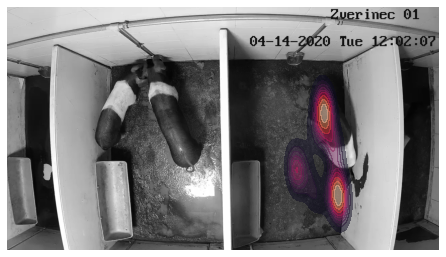

In [99]:

output_dir = Path(f"/storage/plzen4-ntis/projects/korpusy_cv/biomedical/processed/pigtracking/{input_dir.name}")
xx = []
yy = []
for fn in fns:
    output_fn = output_dir / fn.name
    with open(output_fn.with_suffix(".results.json"), "r") as f:
        results = json.load(f)
    for framei, bboxes in zip(results["frame"], results["bboxes"]):
        xx.append(np.mean([bboxes[0][0], bboxes[0][2]]))
        yy.append(np.mean([bboxes[0][1], bboxes[0][3]]))

    points = np.asarray([xx,yy]).T
    points.shape
    visualization.create_heatmap_report(points, frame, output_fn.with_suffix(".jpg"))
points = np.asarray([xx,yy]).T
points.shape
visualization.create_heatmap_report(points, frame, output_dir / "heatmap.jpg")